# Example 2: 2D Doughnuts

## Introduction

In this example we'll take a toy 2D PDF (two rings, with density decreasing with distance from ring) and draw samples from it.

The point of this example is to not only demonstrate some more `lintsampler` usage, but also to illustrate a kind of problem where `lintsampler` might be the method of choice: when you have a highly complex distribution in a few (say, 2-5) dimensions with narrow, well separated modes, `lintsampler` can in some cases out-compete alternative techniques. For example, rejection sampling would be highly inefficient (i.e., a very high rejection rate) unless the proposal distribution is carefully tuned to mirror the structure of the PDF. Similarly, with importance sampling, a small number of the proposals will have excessively large weights, leading to a final sample comprising many repeats a small subsample of proposals. Meanwhile, MCMC methods might struggle if the walkers can't quickly find all of the modes. 

Lintsampling is not without issues here: the user-chosen grid needs to resolve the modes and so might require quite a fine resolution. However, in many cases this is easy and intuitive to set up, provided the grid can fit in memory, the number of necessary PDF evaluations (i.e., number of grid points) is not excessively large, and the user has an a priori sense of what resolution is necessary.

In this notebook we'll try some of these alternative techniques as well, in order to compare with `lintsampler`.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

We'll take 100000 samples throughout the rest of this notebook.

In [4]:
N_SAMPLES = 100000

## Toy model

We'll define a function that evaluates the PDF. The PDF will look like two doughnuts, one centred at $(-18, -18)$ and the other at $(18, 18)$, both with unit radius. Density drops as $e^{-d^2}$ with distance $d$ from the ring. The implementation here is a little hacky, but functional. The function takes in an array of coordinates shaped (N, 2) and returns an array of densities shaped (N).

It's worth noting that the PDF evaluated here is actually not a true PDF, in the sense that we have chucked away any normalising constants. This turns out not to matter, we'll still get samples OK.

This is a _vectorized_ pdf as well, meaning that we can simultaneously ask for $N$ samples. We'll pass a flag to `LintSampler` below letting it know to take advantage of this optimisation.

In [5]:
def circles_pdf(x):
    c1 = np.array([-18.0, -18.0])
    r1 = 1.0
    c2 = np.array([18.0, 18.0])
    r2 = 1.0
    w = 0.4
    
    v1 = x - c1
    v2 = x - c2
    av1 = np.linalg.norm(v1, axis=-1)[:, None]
    av2 = np.linalg.norm(v2, axis=-1)[:, None]
    
    pt1 = np.zeros_like(x)
    pt2 = np.zeros_like(x)
    
    m1 = (av1 == 0).squeeze()
    m2 = (av2 == 0).squeeze()
    pt1[~m1] = c1 + r1 * v1[~m1] / av1[~m1]
    pt2[~m2] = c2 + r2 * v2[~m2] / av2[~m2]
    pt1[m1] = c1 + r1 * np.array([1.0, 0.0])
    pt2[m2] = c2 + r2 * np.array([1.0, 0.0])
    
    d1 = np.linalg.norm(x - pt1, axis=-1)
    d2 = np.linalg.norm(x - pt2, axis=-1)
    
    return np.exp(-0.5 * d1**2 / w**2) + np.exp(-0.5 * d2**2 / w**2)

Let's visualise this PDF:

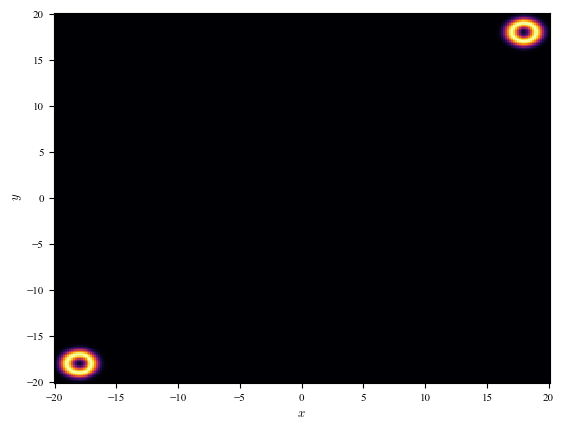

In [6]:
N_grid = 256
Xgrid, Ygrid = np.meshgrid(np.linspace(-20, 20, N_grid), np.linspace(-20, 20, N_grid), indexing='ij')
pos = np.stack((Xgrid, Ygrid), axis=-1).reshape((N_grid**2, 2))
plt.pcolormesh(Xgrid, Ygrid, circles_pdf(pos).reshape((N_grid, N_grid)), cmap='inferno')
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);

## Lintsampling

Having set up our PDF, let's take some samples with `lintsampler`. Let's try and adopt a maximally simple approach, with a single fixed grid. We need to choose a grid resolution for this. The width parameter of the doughnut (not the radius!) of the doughnut is 0.4, so we expect a spatial variation scale of O(0.1). Meanwhile, the domain size is -20 to 20 in both dimensions, so we can manage this with 256 cells along each dimension. 

In [7]:
from lintsampler import LintSampler
domain = (np.linspace(-20, 20, 256), np.linspace(-20, 20, 256))
x_ls = LintSampler(domain, circles_pdf, seed=np.random.default_rng(42), vectorizedpdf=True).sample(N_SAMPLES)

Let's look at the average log-likelihood, for later comparison:

In [8]:
np.log(circles_pdf(x_ls)).mean()

-0.5036390128969591

Also, let's visualise the samples:

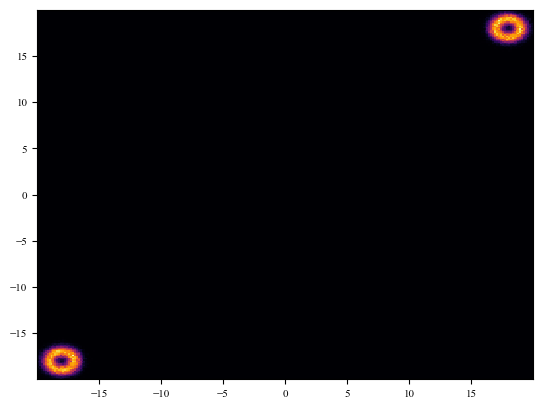

In [9]:
plt.hist2d(*x_ls.T, 256, density=True, cmap='inferno');

These look good!

## Importance Sampling

Now, let's generate importance samples from the same PDF. For a proposal distribution, we can use a uniform distribution from -20 to 20 in both dimensions.

In [10]:
def generate_importance_samples(pdf, N, low, high, rng):
    proposals = rng.uniform(low=low, high=high, size=(N,2))
    weights = pdf(proposals)
    return rng.choice(proposals, N, p=weights / weights.sum())

x_imp = generate_importance_samples(circles_pdf, N_SAMPLES, -20, 20, np.random.default_rng(42))
np.log(circles_pdf(x_imp)).mean()

-0.4934170352863397

The average log-likelihood is basically comparable (we find that different random seeds give different winners here). However, let's visualise the samples:

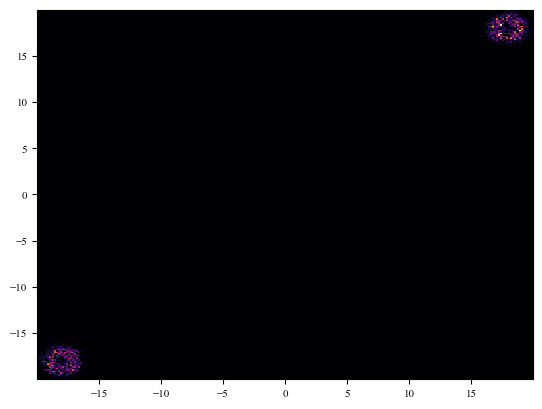

In [11]:
plt.hist2d(*x_imp.T, 256, density=True, cmap='inferno');

We can see doughnuts but why doesn't it look quite the same as the lintsamples, despite being the same sample size? It's because this is actually a small number of samples, repeated many times. To see this, we can ask how many unique rows there are in the array of samples `x_imp`:

In [12]:
len(np.unique(x_imp, axis=0))

1992

So only around 2% of our sample set is unique. This has happened because the (uniform) proposal distribution is not a good match with the target PDF. A small fraction of proposal space contains most of the probability mass. So, a few of the proposals (which happen to be near the doughnuts) get assigned very large 'importances' and so get resampled many times. 

Is this a problem? It depends. In some use cases, such as generating initial particles for a simulation, the large number of repeated samples might well cause issues. On the other hand, if one is drawing samples with the aim of obtaining a Monte Carlo estimate of some summary statistic, then the importance sample estimate still provides an unbiased estimator, albeit one with a higher variance. To see this, let's do a series of random samplings under both techniques, taking a different random seed each time. For each sample set, we'll ask for the mean $x$-value (the 'correct' answer is zero, by symmetry).

In [13]:
m_imp = []
m_ls = []

for seed in range(50):
    x_imp = generate_importance_samples(circles_pdf, N_SAMPLES, -20, 20, np.random.default_rng(seed))
    m_imp.append(np.mean(x_imp[:, 0]))
    
    grid = (np.linspace(-20, 20, 256), np.linspace(-20, 20, 256))
    x_ls = LintSampler(grid, circles_pdf, seed=seed, vectorizedpdf=True).sample(N_SAMPLES)
    m_ls.append(np.mean(x_ls[:, 0]))

Let's look at the variance of both estimates:

In [14]:
print(f"Lintsample variance: {np.var(m_ls)}")
print(f"Importance sample variance: {np.var(m_imp)}")

Lintsample variance: 0.002350676266675916
Importance sample variance: 0.25436712296531216


The variance in the estimate is far higher with importance sampling. To visualise:

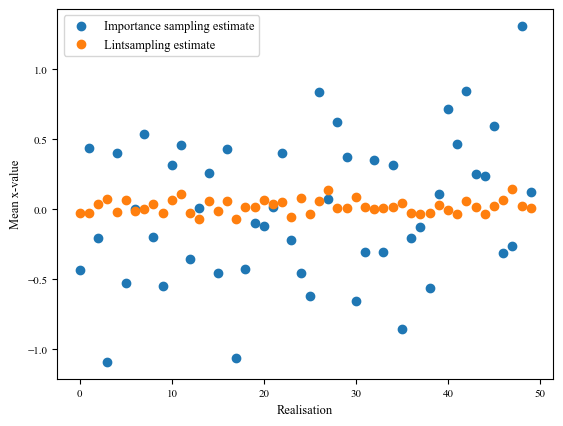

In [15]:
plt.scatter(np.arange(50), m_imp, label='Importance sampling estimate')
plt.scatter(np.arange(50), m_ls, label='Lintsampling estimate')
plt.ylabel("Mean x-value")
plt.xlabel("Realisation")
plt.legend();

## MCMC

For good measure, let's also see what happens under MCMC. We'll use the affine-invariant MCMC implemented by the package `emcee`.

In [16]:
import emcee

First, we'll initialise the walkers.

In [17]:
nwalkers = 100
rng = np.random.default_rng(42)
p0 = rng.uniform(low=-20, high=20, size=(nwalkers,2))

`emcee` wants a log-PDF rather than a PDF. We can write a function for this, simply returning the log of the original PDF (with some extra logic dealing with regions of zero density to avoid taking log(0))

In [18]:
def log_prob(x):
    p = circles_pdf(x)
    lp = np.zeros_like(p)
    m = p == 0
    lp[m] = -1e+10 # give large negative lnp when p==0
    lp[~m] = np.log(p[~m])
    return lp


Burn-in then run MCMC:

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, 2, log_prob, vectorize=True)
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, N_SAMPLES // nwalkers)
x_mcmc = sampler.flatchain

/Users/aneeshnaik/opt/anaconda3/envs/SphinxDocs/lib/python3.12/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/var/folders/mx/jh9lvfpn6rq5ch307g6ln5hr0000gn/T/ipykernel_11530/2380399422.py:26: RuntimeWarning: overflow encountered in divide
  return np.exp(-0.5 * d1**2 / w**2) + np.exp(-0.5 * d2**2 / w**2)
/Users/aneeshnaik/opt/anaconda3/envs/SphinxDocs/lib/python3.12/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


First, let's look at the probability chains, i.e. plot 100 lines (one per walker) showing the log-probability along each walkers path. 

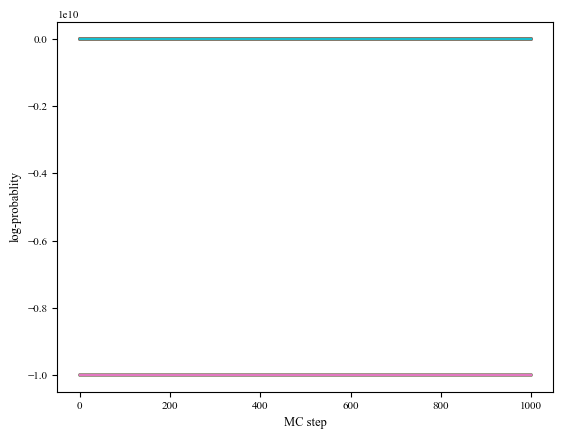

In [20]:
plt.plot(sampler.lnprobability.T)
plt.xlabel('MC step')
plt.ylabel('log-probablity');

This doesn't look super healthy. It seems some walkers (the lower probability ones) never found the modes. Let's show their histogram:

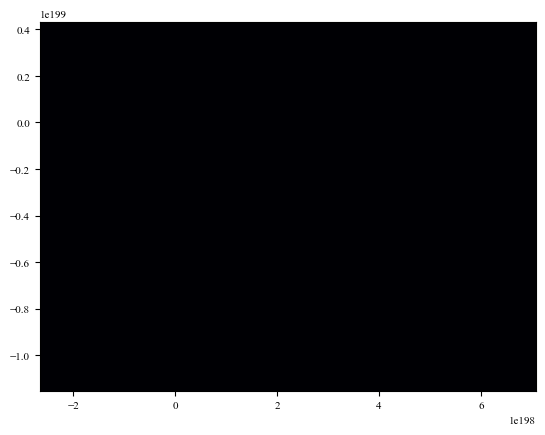

In [21]:
plt.hist2d(*x_mcmc.T, bins=256, density=True, cmap='inferno');

Apparently, some walkers couldn't find the doughnuts and wandered out to vast distances. Let's instead show the histogram of only the points in the region [-20, 20]:

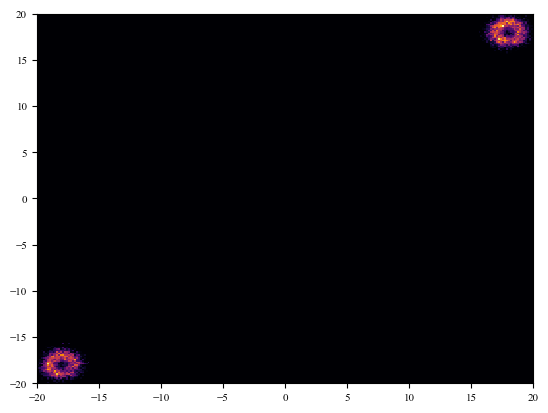

In [22]:
plt.hist2d(*x_mcmc.T, bins=[np.linspace(-20, 20, 256), np.linspace(-20, 20, 256)], density=True, cmap='inferno');

So, the walkers that did find the modes were able to bake some doughnuts, but their friends were lost in the vast wilderness of zero density. `emcee` has a degree of communication between walkers, but apparently this was not enough in this case.

## Summary

In summary, in this example lintsampling gave samples that were more representative of the target PDF, and with lower-variance estimates of summary statistics, than those obtained with either importance sampling and MCMC.

Under all three techniques, we tried to adopt the most basic approach: a fixed grid with evenly-sized cells for lintsampling, a uniform proposal distribution for importance sampling, and a uniform initial walker distribution (and default Gaussian proposal distribution) for MCMC. 

Of course, we could have improved the performance of importance sampling by choosing a better proposal distribution, e.g. two Gaussians centred on the doughnuts. And we could have improved the MCMC performance by choosing an initial walker distribution along similar lines. But then, the same could be said for lintsampler: we could have improved the representativeness of the sample with two grids centred on the doughnuts (as in the docs example). 

Admittedly, the lintsampler setup was not completely agnostic about the PDF: in setting the grid resolution we employed some a priori knowledge of the typical spatial variation scale of the PDF, but we did not need to supply any information about the locations of the modes.

Another point worth emphasising here is the ease of use of lintsampler. A user who is carefully constructing a Bayesian inference pipeline might well take the time to thoroughly explore parameter space and so carefully tune the initial walker distribution to give a well-converged MCMC, but a user who wants to rapidly generate samples from the PDF for some exploratory data analysis or to generate a simple mock dataset can do so using lintsampler with very few lines of code and very little a priori information. They need think only about what is a sufficient grid resolution for their purpose. 

## Bonus: Alternative multigrid approach with `lintsampler`

Using a single space-filling grid with is wasteful in situations like this one, where a lot of space has no mass (e.g., the top left and bottom right). Here we could instead have two $32 \times 32$ grids, one for each ring.

Set up two grids, with edges defined by `e0` and `e1`:

In [27]:
N_grid = 32
e0 = np.linspace(-20, -16, N_grid + 1)
e1 = np.linspace(16, 20, N_grid + 1)

Initialise `LintSampler` and draw samples:

In [28]:
samples = LintSampler([(e0,e0),(e1,e1)],pdf=circles_pdf,seed=rng,vectorizedpdf=True).sample(N=N_SAMPLES)

Visualise:

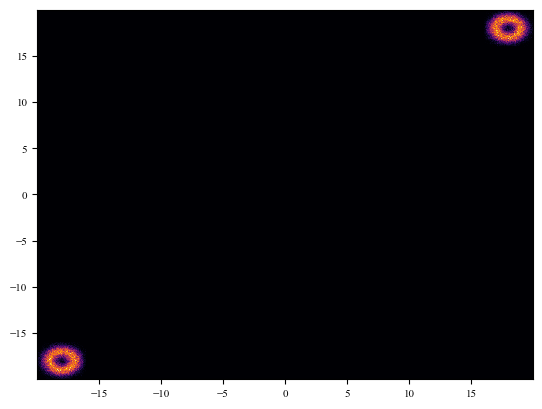

In [29]:
plt.hist2d(samples[:, 0], samples[:, 1], 512, cmap='inferno');

In [30]:
np.log(circles_pdf(samples)).mean()

-0.4863272479558811